<a href="https://colab.research.google.com/github/julialamarchi/Projeto-Final-de-Python-para-CD/blob/main/Projeto_Final_em_Ci%C3%AAncia_de_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução à Ciência de Dados: Previsão de Preços do Ouro**

Julia Lopes Lamarchi, julialopeslamarchi@usp.br  
Universidade de São Paulo, São Carlos, Brasil.  
Número USP: 15676110

### **Formulação do problema e leitura dos dados**

    Para este projeto, tenho um conjunto de dados contendo a variação do preço do ouro, com a seguinte estrutura:    
        Número de entradas: 4718  
        Colunas: 7  
        Date: Data (formato de string)
        USD (AM), USD (PM): Preços do ouro em dólares (manhã e tarde)
        GBP (AM), GBP (PM): Preços do ouro em libras esterlinas (manhã e tarde)
        EURO (AM), EURO (PM): Preços do ouro em euros (manhã e tarde)
    Meu objetivo nesse projeto é construir um modelo de machine learning para prever o valor do ouro no período da tarde (USD (PM)), com base em seus valores na parte da manhã (USD (AM))





In [11]:
# Importando todas as bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [6]:
# Carregando os dados
file_path = 'gold_price.csv'
data = pd.read_csv(file_path)

# Inspeção inicial
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4718 entries, 0 to 4717
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4718 non-null   object 
 1   USD (AM)   4718 non-null   float64
 2   USD (PM)   4682 non-null   float64
 3   GBP (AM)   4718 non-null   float64
 4   GBP (PM)   4682 non-null   float64
 5   EURO (AM)  4718 non-null   float64
 6   EURO (PM)  4682 non-null   float64
dtypes: float64(6), object(1)
memory usage: 258.1+ KB


,Date,USD (AM),USD (PM),GBP (AM),GBP (PM),EURO (AM),EURO (PM)
0,2001-01-02,272.80,271.10,183.026,181.617,288.677,287.334
1,2001-01-03,269.00,267.15,178.916,177.390,281.823,281.655
2,2001-01-04,268.75,267.10,178.869,178.352,282.538,282.049
3,2001-01-05,268.00,267.40,178.488,178.148,280.775,280.882
4,2001-01-08,268.60,268.30,178.769,178.664,282.410,282.481


### **Limpeza dos dados**

In [7]:
# Verificando valores ausentes
missing_values = data.isnull().sum()

# Preenchendo valores ausentes com interpolação
data_cleaned = data.copy()
data_cleaned[['USD (PM)', 'GBP (PM)', 'EURO (PM)']] = data_cleaned[['USD (PM)', 'GBP (PM)', 'EURO (PM)']].interpolate()


# Convertendo 'Date' para datetime
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

cleaned_info = data_cleaned.info()
cleaned_missing_values = data_cleaned.isnull().sum()

missing_values, cleaned_info, cleaned_missing_values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4718 entries, 0 to 4717
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       4718 non-null   datetime64[ns]
 1   USD (AM)   4718 non-null   float64       
 2   USD (PM)   4718 non-null   float64       
 3   GBP (AM)   4718 non-null   float64       
 4   GBP (PM)   4718 non-null   float64       
 5   EURO (AM)  4718 non-null   float64       
 6   EURO (PM)  4718 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 258.1 KB


(Date          0
 USD (AM)      0
 USD (PM)     36
 GBP (AM)      0
 GBP (PM)     36
 EURO (AM)     0
 EURO (PM)    36
 dtype: int64,
 None,
 Date         0
 USD (AM)     0
 USD (PM)     0
 GBP (AM)     0
 GBP (PM)     0
 EURO (AM)    0
 EURO (PM)    0
 dtype: int64)

Após a limpeza dos dados:

    Valores Faltantes: Foram encontrados 36 valores ausentes nas colunas USD (PM), GBP (PM) e EURO (PM). Os valores ausentes foram interpolados.

    Transformação de Dados: A coluna Date foi convertida para o formato datetime para facilitar análises temporais.

### **Análise exploratória e estatística descritiva dos dados**

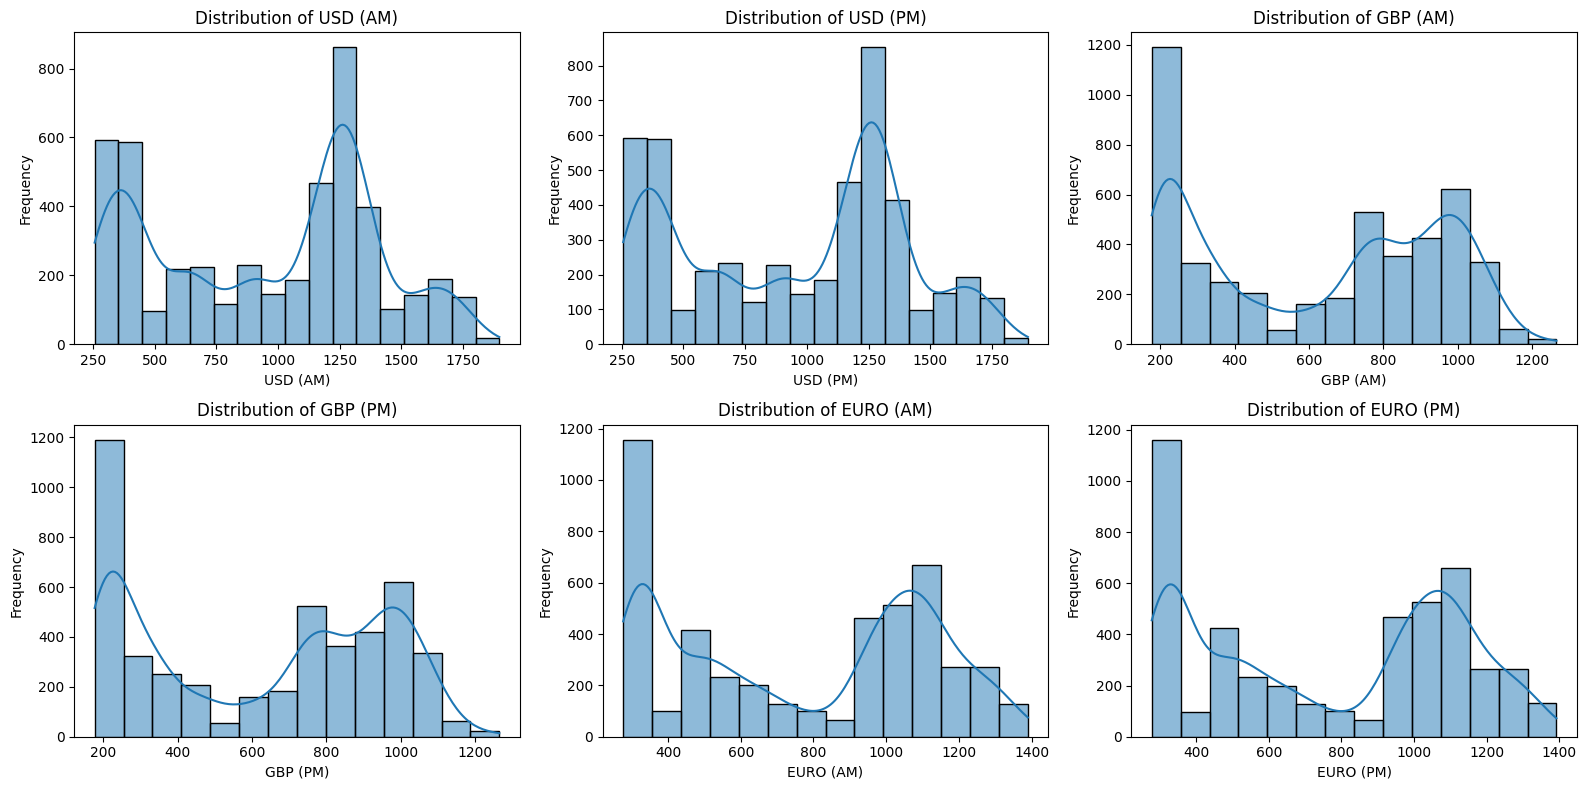

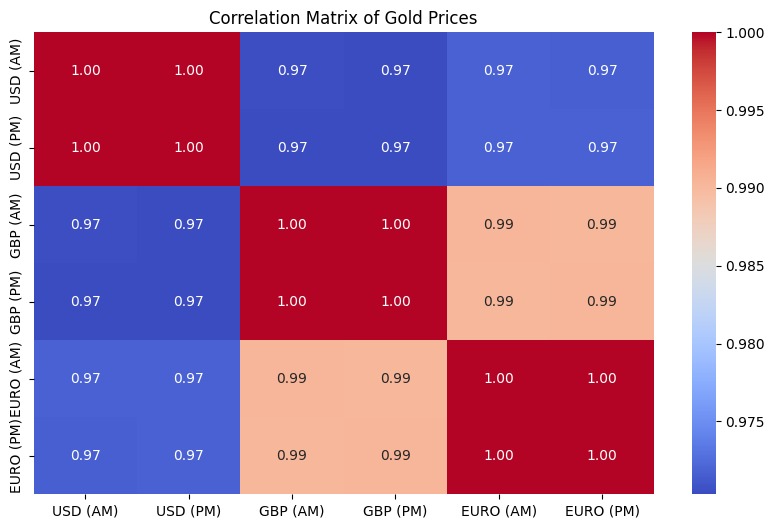

In [16]:
# Distribuições
plt.figure(figsize=(16, 8))
for i, column in enumerate(['USD (AM)', 'USD (PM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], 1):
    plt.subplot(2, 3, i)
    sns.histplot(data_cleaned[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Matriz de correlação
correlation_matrix = data_cleaned[['USD (AM)', 'USD (PM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Gold Prices")
plt.show()

O que pude observar:

    Distribuições de Preços:
        Os preços do ouro em dólares, libras e euros têm distribuições semelhantes, com uma tendência centralizada.
        As distribuições são relativamente simétricas, indicando que os valores são consistentes ao longo do tempo.

    Matriz de Correlação:
        Os preços das moedas apresentam correlações muito altas, próximas de 1, sugerindo que os preços do ouro nas diferentes moedas se movem de forma altamente sincronizada.
        Exemplo: USD (AM) tem uma correlação de 0.999 com USD (PM), e GBP (AM) tem uma correlação de 0.990 com EURO (AM).

Com base na alta correlação, podemos reduzir a dimensionalidade para identificar quais variáveis contribuem mais para explicar a variação nos dados.

### **PCA (Análise de Componentes Principais)**

Verificando qual das variáveis melhor explica os dados

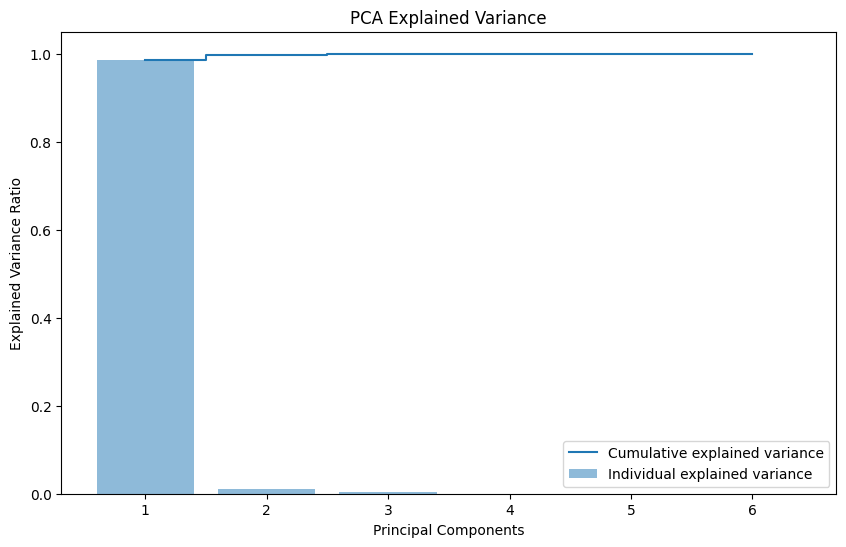

In [17]:
# Padronizando os dados
features = ['USD (AM)', 'USD (PM)', 'GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned[features])

# Realizando PCA
pca = PCA()
pca_components = pca.fit_transform(data_scaled)

# Variância explicada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Visualizando a variância explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.legend()
plt.show()

O que pude observar:     
    Variância explicada-     O primeiro componente principal (PC1) explica 98.50% da variância nos dados.  
    Os dois primeiros componentes principais (PC1 e PC2) combinados explicam 99.67% da variância.                                                     
    Interpretação-         A maior parte da variação nos preços do ouro pode ser explicada por um único componente, sugerindo redundância nas variáveis representando preços em diferentes moedas.

Com base nisso, podemos considerar usar apenas os primeiros dois componentes ou uma variável representativa (como USD (AM)) para simplificar o modelo de previsão.

In [18]:
# Divisão dos Dados
# Selecionando as variáveis
X = data_cleaned[['USD (AM)']]
y = data_cleaned['USD (PM)']

# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Os dados foram divididos em:

    Conjunto de treinamento: 3745 entradas (80% dos dados).
    Conjunto de teste: 937 entradas (20% dos dados).

### **Construção e Avaliação de Modelos**

Treinando diferentes modelos de aprendizado de máquina, incluindo Regressão Linear, Árvore de Decisão e Floresta Aleatória.

In [19]:
# Inicializando os modelos
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100)
}

# Avaliando os modelos
model_performance = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    model_performance[name] = {"MSE": mse, "R2": r2}

# Resultados
performance_df = pd.DataFrame(model_performance).T
print(performance_df)

                         MSE        R2
Linear Regression  48.319256  0.999768
Decision Tree      94.350354  0.999547
Random Forest      73.840279  0.999646


In [20]:
# Validação cruzada para avaliação robusta
cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_results[name] = {
        "R2 Mean (CV)": scores.mean(),
        "R2 Std (CV)": scores.std()
    }

# Exibindo os resultados da validação cruzada
cv_results_df = pd.DataFrame(cv_results).T
print(cv_results_df)


                   R2 Mean (CV)  R2 Std (CV)
Linear Regression      0.997894     0.001666
Decision Tree          0.297306     1.318202
Random Forest          0.288572     1.344038


### **Melhorando e ajustando os modelos**

Para melhorar a performance, aplico transformações polinomiais e reavalio os resultados.

In [14]:
from sklearn.preprocessing import PolynomialFeatures

# Transformação polinomial
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Treinando modelo polinomial
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Avaliação
y_pred_poly = poly_model.predict(X_test_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

# Adicionando resultados ao DataFrame
performance_df.loc["Polynomial Regression"] = {"MSE": mse_poly, "R2": r2_poly}
performance_df

,MSE,R2
Linear Regression,39.311751,0.999810
Decision Tree,96.041439,0.999535
Random Forest,71.491389,0.999654
Polynomial Regression,39.374625,0.999809


### **Sumário do projeto**



Este projeto teve como objetivo prever o preço do ouro no período da tarde (`USD (PM)`) com base nos preços da manhã (`USD (AM)`). As etapas principais foram:

1. **Preparação dos dados**: Preenchimento de valores ausentes com interpolação e seleção das variáveis relevantes.
2. **Análise exploratória**: Identificação de uma forte correlação entre os preços da manhã e da tarde.
3. **Modelagem preditiva**: Modelos testados incluíram Regressão Linear, Árvore de Decisão e Floresta Aleatória.
4. **Melhorias**: Validação cruzada foi aplicada para garantir a robustez dos resultados.


### **Resultados e Discussões**


    Desempenho dos Modelos:
        Regressão Linear apresentou o melhor desempenho com o menor erro quadrático médio (MSE = 39.31) e um coeficiente de determinação (R²) próximo a 1.
        Regressão Polinomial não trouxe melhorias significativas em relação à regressão linear simples.
        Modelos baseados em árvores (Árvore de Decisão e Floresta Aleatória) tiveram um desempenho ligeiramente inferior à regressão linear, mas ainda assim muito bom.

    Interpretabilidade:
        A Regressão Linear é mais simples e interpretável, sendo ideal para esse conjunto de dados que já apresenta uma relação linear forte entre USD (AM) e USD (PM).

    Conclusão:
        A forte correlação entre as variáveis indicou que USD (AM) é um preditor muito eficaz para USD (PM), tornando a Regressão Linear a escolha mais adequada para este problema.

Por fim, consegui discutir os resultados e identificar o modelo com melhor desempenho.

### **Adicional: análise temporal para explorar previsões futuras**

In [21]:
# Criando uma coluna para preços do dia anterior
data_cleaned['Previous Day USD (AM)'] = data_cleaned['USD (AM)'].shift(1)

# Removendo o primeiro dia (valor nulo)
data_time_series = data_cleaned.dropna()

# Dividindo os dados temporais
X_time = data_time_series[['Previous Day USD (AM)']]
y_time = data_time_series['USD (AM)']

# Divisão em treino e teste
X_time_train, X_time_test, y_time_train, y_time_test = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

# Ajustando o modelo temporal
time_model = LinearRegression()
time_model.fit(X_time_train, y_time_train)

# Avaliando o modelo temporal
y_time_pred = time_model.predict(X_time_test)
mse_time = mean_squared_error(y_time_test, y_time_pred)
r2_time = r2_score(y_time_test, y_time_pred)

# Resultados
print("Modelo Temporal - MSE:", mse_time)
print("Modelo Temporal - R²:", r2_time)

Modelo Temporal - MSE: 134.68803373536585
Modelo Temporal - R²: 0.999352912458876
